<a href="https://colab.research.google.com/github/seyone22/ai_testing/blob/main/Books_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Import the movielens dataset into the notebook, and load it with tfds
import tensorflow_datasets as tfds;

ratings_dataset, ratings_dataset_info = tfds.load(
    name='movielens/100k-ratings',
    split='train',
    with_info=True
)

# TODO: Load our book dataset into the notebook.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incomplete4571FG/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


In [ ]:
import tensorflow as tf
assert isinstance(ratings_dataset, tf.data.Dataset)

# Get the size of the dataset (100,000 in this case)
print("ratings_dataset size: %d" % ratings_dataset.__len__())

# See 5 sample elements from the dataset.
print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

ratings_dataset size: 100000
   bucketized_user_age movie_genres movie_id  \
0                 45.0          [7]   b'357'   
1                 25.0      [4, 14]   b'709'   
2                 18.0          [4]   b'412'   
3                 50.0       [5, 7]    b'56'   
4                 50.0     [10, 16]   b'895'   

                                 movie_title  raw_user_age  timestamp  \
0  b"One Flew Over the Cuckoo's Nest (1975)"          46.0  879024327   
1                b'Strictly Ballroom (1992)'          32.0  875654590   
2             b'Very Brady Sequel, A (1996)'          24.0  882075110   
3                     b'Pulp Fiction (1994)'          50.0  883326919   
4                         b'Scream 2 (1997)'          55.0  891409199   

   user_gender user_id  user_occupation_label user_occupation_text  \
0         True  b'138'                      4            b'doctor'   
1         True   b'92'                      5     b'entertainment'   
2         True  b'301'           

In [ ]:
# Map the dataset into an object called rating
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        'user_id' : rating['user_id'],
        'movie_id' : rating['movie_id'],
        'movie_title' : rating['movie_title'],
        'user_rating' : rating['user_rating'],
        'timestamp' : rating['timestamp']
    }
)

print(
    tfds.as_dataframe(ratings_dataset.take(5), ratings_dataset_info)
)

  movie_id                                movie_title  timestamp user_id  \
0   b'357'  b"One Flew Over the Cuckoo's Nest (1975)"  879024327  b'138'   
1   b'709'                b'Strictly Ballroom (1992)'  875654590   b'92'   
2   b'412'             b'Very Brady Sequel, A (1996)'  882075110  b'301'   
3    b'56'                     b'Pulp Fiction (1994)'  883326919   b'60'   
4   b'895'                         b'Scream 2 (1997)'  891409199  b'197'   

   user_rating  
0          4.0  
1          2.0  
2          4.0  
3          4.0  
4          3.0  


In [ ]:
# Split the data into a trainset, and a testset
trainset_size = 0.8 * ratings_dataset.__len__().numpy()

tf.random.set_seed(42)

# Shuffle the dataset
ratings_dataset_shuffled = ratings_dataset.shuffle(
    buffer_size = 100_000,
    seed = 42,
    reshuffle_each_iteration = False
)

# Take out the trainset and testset from the shuffled data
ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_testset = ratings_dataset_shuffled.skip(trainset_size)

# Show how much each dataset has
print(
    "ratings_trainset size: %d" % ratings_trainset.__len__()
)
print(
    "ratings_testset size: %d" % ratings_testset.__len__()
)



ratings_trainset size: 80000
ratings_testset size: 20000


## Preprocessing

In [ ]:
from pprint import pprint

# Show the first element in the trainset.
for rating in ratings_trainset.take(1).as_numpy_iterator():
  pprint(rating)

{'movie_id': b'898',
 'movie_title': b'Postman, The (1997)',
 'timestamp': 885409515,
 'user_id': b'681',
 'user_rating': 4.0}


In [ ]:
# Normalization layer for timestamp. It's a numeric.
timestamp_normalization_layer = \
  tf.keras.layers.experimental.preprocessing.Normalization(axis=None)

timestamp_normalization_layer.adapt(
    ratings_trainset.map(
        lambda x: x['timestamp']
    )
)

for rating in ratings_trainset.take(3).as_numpy_iterator():
  print(
      f"Raw Timestamp: {rating['timestamp']} ->",
      f"Normalized Timestamp: {timestamp_normalization_layer(rating['timestamp'])}"
  )

Raw Timestamp: 885409515 -> Normalized Timestamp: 0.3537561595439911
Raw Timestamp: 883388887 -> Normalized Timestamp: -0.02487170137465
Raw Timestamp: 891249586 -> Normalized Timestamp: 1.4480509757995605


In [ ]:
# Normalization of userIds, to create embeddings
user_id_lookup_layer = \
  tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

print(
    f"Vocabulary[:10] -> {user_id_lookup_layer.get_vocabulary()[:10]}"
)

print(
    "Mapped integer for user ids: ['-2', '13', '655', 'xxx']\n",
    user_id_lookup_layer(
        ['-2', '13', '655', 'xxx']
    )
)

user_id_embedding_dim = 32

user_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=user_id_lookup_layer.vocabulary_size(),
    output_dim=user_id_embedding_dim
)

user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)

print(
    "Embeddings for user ids: ['-2', '13', '655', 'xxx]\n",
    user_id_model(
        ['-2', '13', '655', 'xxx']
    )
)

Vocabulary[:10] -> ['[UNK]', '405', '655', '13', '450', '276', '303', '416', '537', '234']
Mapped integer for user ids: ['-2', '13', '655', 'xxx']
 tf.Tensor([0 3 2 0], shape=(4,), dtype=int64)
Embeddings for user ids: ['-2', '13', '655', 'xxx]
 tf.Tensor(
[[ 0.02112819  0.00262235 -0.02042791  0.04211975 -0.02216019  0.03135623
  -0.00802011  0.01017022  0.04799832  0.021168    0.04570783  0.01806263
  -0.01670346  0.04920539 -0.021676   -0.03416904 -0.03673298 -0.02711605
  -0.00583205  0.0274017   0.04901491 -0.01575196  0.00350817  0.00945561
   0.04201725 -0.01290593 -0.03604493 -0.03572863  0.00432992 -0.04707686
   0.00760179  0.02500672]
 [-0.01197063 -0.04320464 -0.0058319  -0.00313162  0.03246048  0.0443706
   0.00312611 -0.04078434  0.02966878 -0.01190946 -0.04038477  0.0242837
   0.01476398 -0.01316309  0.0062896   0.03323462 -0.00045869  0.03286381
   0.0078728  -0.00334858  0.00123562  0.02519168  0.0096177  -0.04310676
   0.00112069  0.04221225  0.01914642  0.01149434 -0

In [ ]:
# Normaliation of movie_Id, to create embeddings
movie_id_lookup_layer = \
  tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)

movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

movie_id_embedding_dim = 32

movie_id_embedding_layer = tf.keras.layers.Embedding(
    input_dim=movie_id_lookup_layer.vocab_size(),
    output_dim=movie_id_embedding_dim
)

movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

print(
    f"Embedding for the movie 898:\n {movie_id_model('898')}"
)

Embedding for the movie 898:
 [ 0.01248167  0.03173753 -0.02201745 -0.03709877 -0.01106628  0.04616568
  0.00935204 -0.01339965 -0.04600736 -0.02841519  0.03094841 -0.02536848
 -0.03632555 -0.04773235  0.00893506  0.04023707  0.02679918 -0.02874419
 -0.03192308 -0.03390054  0.04741396  0.00069331 -0.00847106 -0.03336622
 -0.01280396 -0.00882554 -0.04911814  0.00769348 -0.03936279 -0.02116586
 -0.00080782  0.00164226]


In [ ]:
# Vectorize the movie title,
movie_title_vectorization_layer = \
  tf.keras.layers.experimental.preprocessing.TextVectorization()
movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

print(
    "Vocabulary[40:50] -> ",
    movie_title_vectorization_layer('Postman, The (1997)')
)

movie_title_embedding_dim = 32
movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(movie_title_vectorization_layer.get_vocabulary()),
    output_dim=movie_title_embedding_dim,
    mask_zero=True
)

movie_title_model = tf.keras.Sequential(
    [
        movie_title_vectorization_layer,
        movie_title_embedding_layer,
        tf.keras.layers.GlobalAveragePooling1D()
    ]
)

Vocabulary[40:50] ->  tf.Tensor([1120    2    4], shape=(3,), dtype=int64)


## Query and Candidate Representation


In [ ]:
# We're using the userIds as the query model, and movieIds as the candidate model
# (Inputs and outputs)
query_model = user_id_model
candidate_model = movie_id_model

retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id' : rating['user_id'],
        'movie_id' : rating['movie_id']
    }
)
retrieval_ratings_testset = ratings_testset.map(
    lambda rating: {
        'user_id' : rating['user_id'],
        'movie_id' : rating['movie_id']
    }
)

In [91]:
# Load the movie data
movies_dataset, movies_dataset_info = tfds.load(
    name='movielens/100k-movies',
    split='train',
    with_info=True
)

# Print the loaded data as a dataframe
print(
    tfds.as_dataframe(movies_dataset.take(5), movies_dataset_info)
)

candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

# See 5 sample elements from the dataset.
print(
    tfds.as_dataframe(movies_dataset.take(5), movies_dataset_info)
)


  movie_genres movie_id                      movie_title
0          [4]  b'1681'           b'You So Crazy (1994)'
1       [4, 7]  b'1457'   b'Love Is All There Is (1996)'
2       [1, 3]   b'500'          b'Fly Away Home (1996)'
3          [0]   b'838'  b'In the Line of Duty 2 (1987)'
4          [7]  b'1648'       b'Niagara, Niagara (1997)'
  movie_genres movie_id                      movie_title
0          [4]  b'1681'           b'You So Crazy (1994)'
1       [4, 7]  b'1457'   b'Love Is All There Is (1996)'
2       [1, 3]   b'500'          b'Fly Away Home (1996)'
3          [0]   b'838'  b'In the Line of Duty 2 (1987)'
4          [7]  b'1648'       b'Niagara, Niagara (1997)'


In [ ]:
# Install tensorflow recommenders
!pip install -q scann tensorflow-recommenders
import tensorflow_recommenders as tfrs

# This is the metric by which we'll be measuring the perfomrance of our model
factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates=candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

# Create the retrieval task
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics=factorized_top_k_metrics
)

SyntaxError: invalid syntax (<ipython-input-17-368aa83d3479>, line 2)

In [ ]:
class RetrievalModel(tfrs.models.Model):
  """MovieLens candidate generation model"""

  def __init__(self, query_model, candidate_model, retrieval_task_layer):
    super().__init__()
    self.query_model: tf.keras.Model = query_model
    self.candidate_model: tf.keras.Model = candidate_model
    self.retrieval_task_layer: tf.keras.layers.Layer = retrieval_task_layer

 #def compute_loss(self, features: Dict[Text, tf.Tensor], training=False):
  def compute_loss(self, features, training=False) -> tf.Tensor:
    query_embeddings = self.query_model(features['user_id'])
    positive_candidate_embeddings = self.candidate_model(features["movie_id"])

    loss = self.retrieval_task_layer(
        query_embeddings,
        positive_candidate_embeddings
        # ,compute_metrics=not training  # To speed up training
    )
    return loss

In [ ]:
# Create the retrieval model
movielens_retrieval_model = RetrievalModel(
    query_model,
    candidate_model,
    retrieval_task_layer
)

# Optimization here...
optimizer_step_size = 0.1
movielens_retrieval_model.compile(
    optimizer=tf.keras.optimizers.Adagrad(
        learning_rate=optimizer_step_size
    )
)

# Shuffle the trainset and the testset, and cache it.
retrieval_cached_ratings_trainset = \
  retrieval_ratings_trainset.shuffle(100_000).batch(8192).cache()
retrieval_cached_ratings_testset = \
  retrieval_ratings_testset.batch(4096).cache()

#  Train the model!
num_epochs = 5
history = movielens_retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    validation_data=retrieval_cached_ratings_testset,
    validation_freq=1,
    epochs=num_epochs
)

Epoch 1/5
10/10 [==============================] - 67s 6s/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accuracy: 0.0272 - factorized_top_k/top_10_categorical_accuracy: 0.0564 - factorized_top_k/top_50_categorical_accuracy: 0.2381 - factorized_top_k/top_100_categorical_accuracy: 0.3865 - loss: 63963.3778 - regularization_loss: 0.0000e+00 - total_loss: 63963.3778 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0016 - val_factorized_top_k/top_10_categorical_accuracy: 0.0045 - val_factorized_top_k/top_50_categorical_accuracy: 0.0693 - val_factorized_top_k/top_100_categorical_accuracy: 0.1751 - val_loss: 29415.6641 - val_regularization_loss: 0.0000e+00 - val_total_loss: 29415.6641
Epoch 2/5
10/10 [==============================] - 41s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0043 - factorized_top_k/top_5_categorical_accuracy: 0.0343 - factorized_top_k/top_10_

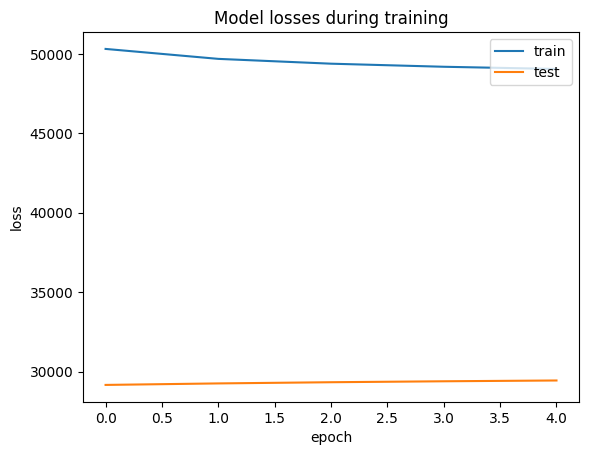

In [ ]:
import matplotlib.pyplot as plt

# Plot a graph to show the model losses during training
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"], loc="upper right")
plt.show()

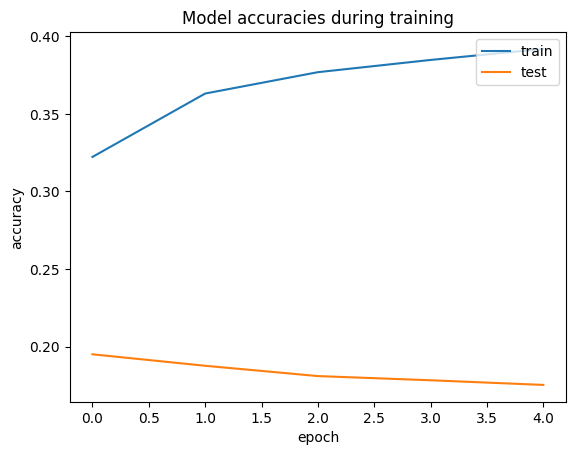

In [ ]:
# Plot to show the accuracy of the model during training
plt.plot(history.history["factorized_top_k/top_100_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [ ]:
# Using the created model, this will brute force the top recommendations
brute_force_layer = tfrs.layers.factorized_top_k.BruteForce(
    movielens_retrieval_model.query_model
)

brute_force_layer.index_from_dataset(
    tf.data.Dataset.zip(
        (
            candidates_corpus_dataset.batch(100),
            candidates_corpus_dataset.batch(100).map(
                movielens_retrieval_model.candidate_model
            )
        )
    )
)

In [ ]:
# Test the retrieval
user_id = '42'
afinity_scores, movie_ids = brute_force_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using BruteForce: {movie_ids[0, :5]}")

Recommendations for user 42 using BruteForce: [b'1043' b'280' b'1032' b'925' b'369']


In [ ]:
# Using the created model, this will use ScaNN to get the top recommendations
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    movielens_retrieval_model.query_model
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          candidates_corpus_dataset.batch(100),
          candidates_corpus_dataset.batch(100).map(
              movielens_retrieval_model.candidate_model
          )
      )
  )
)

user_id = '42'
afinity_scores, movie_ids = scann_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]}")

Recommendations for user 42 using ScaNN: [b'925' b'280' b'756' b'105' b'1291']


## Save the Model

In [ ]:
# DOESN'T WORK YET.
import os
import tempfile

with tempfile.TemporaryDirectory() as tmp_dir:
  retrieval_model_path = os.path.join(tmp_dir, "retrieval_model")


scann_layer.save_weights(retrieval_model_path)

In [ ]:
# Reload the saved model to confirm that it works correctly
model = tfrs.models.RetrievalModel(
    user_model=user_model,
    item_model=item_model,
    task=task
)
model.compile()
model.load_weights(retrieval_model_path)

print(f"Recommendations for user {user_id} using reloaded saved model: {movie_ids[0, :5]}")

AssertionError: Nothing except the root object matched a checkpointed value. Typically this means that the checkpoint does not match the Python program. The following objects have no matching checkpointed value: [<tf.Variable 'iteration:0' shape=() dtype=int64, numpy=0>, <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>]